In [1]:
from MDAnalysis import Universe
import pandas as pd
import numpy as np

from marching_cubes import march
from seaborn import kdeplot
import matplotlib.pyplot as plt
%matplotlib inline

import plotly
import plotly.graph_objs as go

import meshplex

import fresnel

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

from scipy.spatial.distance import cdist,pdist,squareform

from skimage import measure

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def golden_spiral(num_pts, radius):
    if radius==0:
        return np.array([[0,0,0]])
    indices = np.arange(0, num_pts, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/num_pts)
    theta = np.pi * (1 + 5**0.5) * indices
    x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi);
    points = np.vstack([x,y,z]).T
    return points*radius

def plotly_scatter(pointsets, sizes):
    data = []
    for p, s in zip(pointsets, sizes):
        a,b,c = p[:,0], p[:,1], p[:,2]
        trace = go.Scatter3d(x=a, y=b, z=c, mode='markers', marker={'size': s,'opacity': 0.8,})
        data.append(trace)
    layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
    plot_figure = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(plot_figure)
    
def fresnel_mesh(vol, cutoff, n_samples=10, view=None, spacing=(1,1,1)):
    if view is not None:
        view = view
    else:
        view='front'
    #vert, norm, faces = march(vol, smooth) 
    vert, faces, norm, values= measure.marching_cubes_lewiner(vol, cutoff,spacing=(1,1,1))
    scene1 = fresnel.Scene()
    geom = fresnel.geometry.Mesh(scene1,vertices=vert[faces].reshape(-1,3),N=1)
    geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
    scene1.camera = fresnel.camera.fit(scene1,view=view, margin=0)
    scene1.lights = fresnel.light.cloudy()
    return fresnel.pathtrace(scene1, samples=n_samples, h=600, w=600)

In [3]:
stamp = golden_spiral(100, 1)
atom_centres = np.random.uniform(0,10,(20,3))
surface_points = (stamp + atom_centres[:,None]).reshape(-1,3)
normals = surface_points.copy()

distances = cdist(surface_points, atom_centres)
mask = distances.min(1)>=1-0.001
surface_points = surface_points[mask]
normals = normals[mask]

In [210]:

import meshplex
tetra = Delaunay(surface_points)
node_coords = surface_points.copy()
cells = tetra.simplices
mesh = meshplex.MeshTetra(node_coords, cells)

In [211]:
mesh.create_cell_face_relationships()

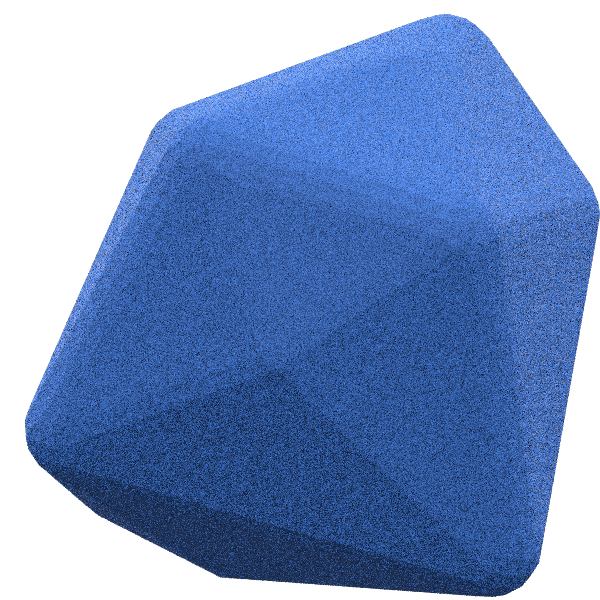

In [212]:

scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=surface_points[mesh.faces['nodes']].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
scene1.camera = fresnel.camera.fit(scene1,view='front', margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=10, h=600, w=600)

In [198]:

f = open('test.obj', 'w')
for v in surface_points:
    f.write('v '+str(v[0])+' '+str(v[1])+' '+str(v[2])+'\n')
    
for v in mesh.faces['nodes']:
    f.write('vn '+str(v[0])+' '+str(v[1])+' '+str(v[2])+'\n')
f.close()

In [180]:
plotly_scatter([surface_points], [10])

In [181]:
from scipy.spatial import Delaunay
import numpy as np
from collections import defaultdict

def alpha_shape_3D(pos, alpha):
    """
    Compute the alpha shape (concave hull) of a set of 3D points.
    Parameters:
        pos - np.array of shape (n,3) points.
        alpha - alpha value.
    return
        outer surface vertex indices, edge indices, and triangle indices
    """

    tetra = Delaunay(pos)
    node_coords = pos.copy()
    cells=tetra.simplices
    r = mesh.cell_circumradius
#     # Find radius of the circumsphere.
#     # By definition, radius of the sphere fitting inside the tetrahedral needs 
#     # to be smaller than alpha value
#     # http://mathworld.wolfram.com/Circumsphere.html
#     tetrapos = np.take(pos,tetra.vertices,axis=0)
#     normsq = np.sum(tetrapos**2,axis=2)[:,:,None]
#     ones = np.ones((tetrapos.shape[0],tetrapos.shape[1],1))
#     a = np.linalg.det(np.concatenate((tetrapos,ones),axis=2))
#     Dx = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[1,2]],ones),axis=2))
#     Dy = -np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[0,2]],ones),axis=2))
#     Dz = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[0,1]],ones),axis=2))
#     c = np.linalg.det(np.concatenate((normsq,tetrapos),axis=2))
#     r = np.sqrt(Dx**2+Dy**2+Dz**2-4*a*c)/(2*np.abs(a))

    # Find tetrahedrals
    tetras = tetra.vertices[r<alpha,:]
    # triangles
    TriComb = np.array([(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)])
    Triangles = tetras[:,TriComb].reshape(-1,3)
    Triangles = np.sort(Triangles,axis=1)
    # Remove triangles that occurs twice, because they are within shapes
    TrianglesDict = defaultdict(int)
    for tri in Triangles:TrianglesDict[tuple(tri)] += 1
    Triangles=np.array([tri for tri in TrianglesDict if TrianglesDict[tri] ==1])
    #edges
    EdgeComb=np.array([(0, 1), (0, 2), (1, 2)])
    Edges=Triangles[:,EdgeComb].reshape(-1,2)
    Edges=np.sort(Edges,axis=1)
    Edges=np.unique(Edges,axis=0)

    Vertices = np.unique(Edges)
    return Vertices,Edges,Triangles



In [185]:
verts, edges, tris = alpha_shape_3D(surface_points, 10)

In [ ]:
mesh.create_cell_face_relationships()

In [187]:
plotly_scatter([surface_points,surface_points[verts]], [10,2])

In [9]:
import pygmsh
import numpy as np

geom = pygmsh.built_in.Geometry()

# Draw a cross.
poly = geom.add_polygon([
    [ 0.0,  0.5, 0.0],
    [-0.1,  0.1, 0.0],
    [-0.5,  0.0, 0.0],
    [-0.1, -0.1, 0.0],
    [ 0.0, -0.5, 0.0],
    [ 0.1, -0.1, 0.0],
    [ 0.5,  0.0, 0.0],
    [ 0.1,  0.1, 0.0]
    ],
    lcar=0.05
)

axis = [0, 0, 1]

geom.extrude(
    poly,
    translation_axis=axis,
    rotation_axis=axis,
    point_on_axis=[0, 0, 0],
    angle=2.0 / 6.0 * np.pi
)

mesh = pygmsh.generate_mesh(geom)

Info    : Running 'gmsh -3 /var/folders/1k/ppzhvkpx7pjg4jnc26qbz_4m0000gp/T/tmpwzkg2q9g.geo -format msh -bin -o /var/folders/1k/ppzhvkpx7pjg4jnc26qbz_4m0000gp/T/tmp78z_a345.msh' [Gmsh 4.5.4-git-5a16799, 1 node, max. 1 thread]
Info    : Started on Thu Mar 19 09:38:45 2020
Info    : Reading '/var/folders/1k/ppzhvkpx7pjg4jnc26qbz_4m0000gp/T/tmpwzkg2q9g.geo'...
Info    : Done reading '/var/folders/1k/ppzhvkpx7pjg4jnc26qbz_4m0000gp/T/tmpwzkg2q9g.geo'
Info    : Meshing 1D...
Info    : [  0 %] Meshing curve 1 (Line)
Info    : [ 10 %] Meshing curve 2 (Line)
Info    : [ 10 %] Meshing curve 3 (Line)
Info    : [ 20 %] Meshing curve 4 (Line)
Info    : [ 20 %] Meshing curve 5 (Line)
Info    : [ 30 %] Meshing curve 6 (Line)
Info    : [ 30 %] Meshing curve 7 (Line)
Info    : [ 30 %] Meshing curve 8 (Line)
Info    : [ 40 %] Meshing curve 12 (Line)
Info    : [ 40 %] Meshing curve 13 (Line)
Info    : [ 50 %] Meshing curve 14 (Line)
Info    : [ 50 %] Meshing curve 15 (Line)
Info    : [ 50 %] Meshing curv

In [10]:
mesh.cells


[CellBlock(type='vertex', data=array([[0]])),
 CellBlock(type='vertex', data=array([[1]])),
 CellBlock(type='vertex', data=array([[2]])),
 CellBlock(type='vertex', data=array([[3]])),
 CellBlock(type='vertex', data=array([[4]])),
 CellBlock(type='vertex', data=array([[5]])),
 CellBlock(type='vertex', data=array([[6]])),
 CellBlock(type='vertex', data=array([[7]])),
 CellBlock(type='vertex', data=array([[8]])),
 CellBlock(type='vertex', data=array([[9]])),
 CellBlock(type='vertex', data=array([[10]])),
 CellBlock(type='vertex', data=array([[11]])),
 CellBlock(type='vertex', data=array([[12]])),
 CellBlock(type='vertex', data=array([[13]])),
 CellBlock(type='vertex', data=array([[14]])),
 CellBlock(type='vertex', data=array([[15]])),
 CellBlock(type='vertex', data=array([[16]])),
 CellBlock(type='vertex', data=array([[17]])),
 CellBlock(type='vertex', data=array([[18]])),
 CellBlock(type='vertex', data=array([[19]])),
 CellBlock(type='vertex', data=array([[20]])),
 CellBlock(type='vertex